퍼셉트론 모델은 linear regression과 굉장히 유사한 형태, sigmoid를 사용하면 logistic regression
linear regression의 경우에는 weight를 다 기억할 필요 없지만 퍼셉트론 모델을 layer가 깊어질 수록 memory에 기억해야할 weight가 늘어난다.
따라서 한번에 모든 데이터를 학습하지 않도록 batch 단위로 잘라서 batch_size별로 반복한다.

# 00. Load data & Preprocessing

In [1]:
import os
from collections import Counter
import random

from tqdm import tqdm

import pandas as pds
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sbn

from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold



def cat_transform(df, cs):
    return_list = []
    numeric_columns = []
    
    for c in cs:
        # categorical column list 'cs' 중 하나인 "c"에 존재하는 고윳 값들 전부에 대응되는 숫자 생성
        unique_values = {i : n for n,i in enumerate(sorted(df[c].unique()))}
        
        # lambda를 활용하여 dataframe의 c column에 존재하는 각 값들을 숫자로 변환
        num_df = df[c].apply(lambda x: unique_values[x])
        
        # 만약 고윳값이 2개인 경우, 1열로 표현 가능 ( e.g. 0 - 1 or -1 - 1 )
        if len(unique_values) == 2:
            return_list.append(num_df.values.reshape(-1,1))
        
        # 만약 고윳값이 3개 이상인 경우, 고윳값 갯수만큼의 열을 활용한 one-hot encoding을 수행해야 함.
        # 단 너무 많은 고윳값의 경우 discrete numerical variables일 수 있기 때문에, one-hot encoding에서 제외함
        elif len(unique_values) < 10:
            return_list.append(np.eye(len(unique_values))[num_df])

        # 제외한 column들을 return하여 numerical preprocessing을 적용
        else:
            numeric_columns.append(c)
    return np.concatenate(return_list, 1), numeric_columns


def num_transform(df, cs):
    num_df = df[cs].copy().values
    
    #열별 평균으로 빼고 분산을 1로 변환하는 Standard scaling (a.k.a z-scaling)
    num_df = (df[cs].values - num_df.mean(0)) / (num_df.std(0) + 1e-10)
    return num_df


# Argument data_x, data_y는 numpy.array
def ss_kfold_fn(data_x, data_y, scaling = True):
    kf = StratifiedKFold()
    for n, (train_idx, valid_idx) in enumerate(kf.split(data_x, data_y)):
        
        scaler_x = StandardScaler()
        
        if scaling:
            
            train_x = scaler_x.fit_transform(data_x[train_idx])
            valid_x = scaler_x.transform(data_x[valid_idx])
            
        else:
            # numpy.array indexing
            train_x = data_x[train_idx]
            valid_x = data_x[valid_idx]

        
        train_y = data_y[train_idx]
        valid_y = data_y[valid_idx]
        
        # "yield"는 iterative type object를 반복문 순서에 따라 return 하는 기능을 지원함.
        yield [
            [train_x, train_y],
            [valid_x, valid_y]
        ], (scaler_x)

        
        
df = pds.read_csv(
    os.path.join('../files/Week 10. data-student.csv')
    , delimiter=';'
)
Y = df['Target']
Y = Y.apply(lambda x: 0 if x == 'Graduate' else (1 if x == 'Enrolled' else 2 )).values
X = df.drop(columns = ['Target'], axis = 1)

remove_columns = []
categorical_columns = []
numerical_columns = []

# 열별로 데이터 탐색 진행 = column을 순차대로 탐색하는 것과 같음
for c, t in X.iteritems():
    
    # 데이터가 만약 수치형이 아니라면 categorical에 대해 고민해 볼 필요 있음
    if t.dtype != np.float64:
        
        # 데이터에 존재하는 고윳값 갯수 계산
        n_unique = len(t.unique())
        
        # 고윳값이 단 하나라면 필요 없는 데이터일수 있음
        if n_unique == 1:
            remove_columns.append(c)
            
        # 아니라면 categorical preprocessing 적용
        else:
            categorical_columns.append(c)
            
    # 수치형이라면, 수치형에 대한 preprocessing 적용 
    else:
        numerical_columns.append(c)

cat_arr, add_numerical_columns = cat_transform(df, categorical_columns)
num_arr = num_transform(df, numerical_columns + add_numerical_columns)
df_arr = np.concatenate([num_arr, cat_arr], 1)

g = ss_kfold_fn(df_arr, Y, False)

(train, valid), s = next(g)

# 01. Deep learning pipe line

<img src = https://imgur.com/NVF2TRf.png width = 600>




이전 시간까지 배운 ML 모델들과 신경망 모델들은 학습하는 방법에서 큰 차이를 갖습니다. 

가장 큰 차이는 데이터 $x$로부터 타겟 $y$를 가장 잘 설명할 수 있는 파라미터 $\theta$를 구하기 위해, 타겟 $y$와 모델이 예측한 타겟 $\hat{y}$의 차를 최소화하도록 모델의 파라미터를 근사시킨다는 점입니다.

신경망 학습 과정에서 타겟 $y$와 모델이 예측한 타겟 $\hat{y}$의 차를 손실(loss)라고 부릅니다.  

그리고 loss를 최소화 또는 수렴시켜 최적의 해를 찾는 과정을 최적화(opmization)라고 합니다. 

신경망 학습을 위해 아래 요소들을 설정해야 합니다. 

    1. 데이터 로더  full batch?
    2. 모델 구조
    3. 손실 함수 
    4. Optimizer
    5. 평가 지표

## 01-00. Pytorch

<img src = https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/PyTorch_logo_black.svg/120px-PyTorch_logo_black.svg.png width = 150>

[PyTorch](https://en.wikipedia.org/wiki/PyTorch) is a machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, originally developed by Meta AI and now part of the Linux Foundation umbrella.  

It is free and open-source software released under the modified BSD license.  

Although the Python interface is more polished and the primary focus of development, PyTorch also has a C++ interface.

[Installation Guide](https://pytorch.org/get-started/previous-versions/)

In [2]:
import torch
import pytorch_lightning as pl
import torchmetrics

## 01-01. Pytorch dataloader

Pytorch dataloader는 batch 단위의 데이터를 torch의 data type으로 관리하는 것을 도와주는 클래스입니다. 

먼저, torch dataset을 활용하여 인덱스를 입력하면 데이터를 불러오는 오브젝트를 생성합니다. 

그리고 생성한 dataset 오브젝트를 torch dataloader에 전달해주면, 매 학습 epoch마다 지정된 batch size의 데이터를 불러오도록 도와줍니다. 

In [3]:
# 데이터 셋 클래스의 목표는 하나입니다. 
# 파이토치 학습 프레임워크에서 데이터에 존재할 수 있는 특정 인덱스를 호출했을 때, 인덱스에 해당하는 데이터들을 리턴하는 것 입니다. 
# 불러온 데이터들은 모델의 입출력에 맞는 데이터를 불러와야 합니다. 

class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y = None, training = True):
        super().__init__()
        
        self._training = training
        self._X = x.astype(np.float32)
        if self._training:
            self._Y = y
            
    def __len__(self):
        return len(self._X)
    
    
    def __getitem__(self, idx):
        if self._training:
            return self._X[idx], self._Y[idx]
        else:
            return self._X[idx]

# Pytorch lightning은 pytorch 과정에서 항상 똑같이 반복되는 코드들을 사용자가 작성하지 않도록 도와줌으로써 피로도를 감소시킵니다. 
# Pytorch lightning datamodule 클래스를 활용하여, torch dataloader가 lightning에서 사용할 수 있도록 호환시킬 수 있습니다.

        
class pl_datamodule(pl.LightningDataModule):
    def __init__(self, train, valid, batch_size = 64):
        super().__init__()
        self._train = train
        self._valid = valid
        self._batch_size = batch_size
        
                     
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = custom_dataset(*self._train)
            self.valid_dataset = custom_dataset(*self._valid)

        elif stage == "test" or stage is None:
            pass
                     
                     
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size = self._batch_size, shuffle = True)
                     
        
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_dataset, batch_size = self._batch_size, shuffle = False)

In [4]:
DM = pl_datamodule(train, valid, 16)
DM.setup('fit')

In [5]:
# 고정된 데이터 순서의 반복은 학습에 영향을 끼칩니다. 
# 따라서 학습과정을 위한 데이터 로더는 반복할때마다 데이터가 섞이게 됩니다. 

for torch_x, torch_y in DM.train_dataloader():
    break
print(torch_x.shape, torch_y.shape)
print(torch_x[0], torch_y[0])

torch.Size([16, 48]) torch.Size([16])
tensor([ 0.7877,  0.8993,  0.7526,  0.7784,  0.4257,  1.7880, -0.7499, -1.0107,
         0.3118, -0.3502, -0.1263,  1.1818,  1.0250, -0.0742, -0.0805, -0.5622,
        -0.3008,  0.6974, -0.0716,  0.7413, -0.1993, -0.2824,  0.8051, -0.0160,
         0.8506, -0.1994,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000]) tensor(0)


In [6]:
# 고정된 데이터 순서의 반복은 학습에 영향을 끼칩니다. 
# 한편 검증은 모델의 파라미터를 학습하지 않기 떄문에, 항상 고정된 순서로 검증해도 무방합니다.

for torch_x, torch_y in DM.val_dataloader():
    break
print(torch_x.shape, torch_y.shape)
print(torch_x[0], torch_y[0])

torch.Size([16, 48]) torch.Size([16])
tensor([-0.8048,  0.0222, -2.1971, -1.9635, -0.2876,  0.1244,  0.7658, -0.0955,
        -4.2095, -0.3502, -0.1263, -0.0360, -0.6698, -0.2257, -0.0805, -0.4304,
        -0.3008, -2.5286, -1.9861, -1.5213, -0.1993, -0.2824, -2.8383, -2.0426,
        -1.4715, -0.1994,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000]) tensor(2)


## 01-02. Pytorch Model

Pytorch는 deep learning을 위한 가장 많이 사용되는 패키지 중 하나입니다. 

Pytorch의 장점 중 하나는 neural layer의 연결 과정에서 python coding style을 고수한다는 사실입니다. 

아래 pytorch lightning module을 활용하여 pytorch의 학습 과정을 보다 간소화 할 수 있습니다. 



In [7]:
l = [21,64,64,3]

for i, o in zip(l, l[1:]):
    print(i,o)
else:
    print('end')

21 64
64 64
64 3
end


In [8]:
class pl_model(pl.LightningModule):
    def __init__(self, dims, lr = 1e-3, device = None):
        super().__init__()
            
        self.input_dims = dims
        self.output_dims = dims[1:]
        self.dims_flag = [False] * (len(self.output_dims) - 1) + [True]
        self._lr = lr
        
        self.build_model()
        
        self.loss_fn = torch.nn.CrossEntropyLoss()
        
        self.acc_fn = torchmetrics.Accuracy(num_classes = dims[-1])
        self.auc_fn = torchmetrics.AUROC(num_classes = dims[-1])
        self.f1_fn = torchmetrics.F1Score(num_classes = dims[-1], average = 'macro')
        
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self._lr)

    
    def build_block(self, i, o, output_flag = False):
        if output_flag:
            return torch.nn.Linear(i,o)
        else:
            return torch.nn.Sequential(
                torch.nn.Linear(i, o),
#                 torch.nn.BatchNorm1d(o),
                torch.nn.ReLU(),
#                 torch.nn.Dropout(),
            )
    
    
    def build_model(self):
        nets = []
        for i,o,f in zip(self.input_dims, self.output_dims, self.dims_flag):
            print(i,o,f)
            nets.append(self.build_block(i,o,f))
        self.net = torch.nn.ModuleList(nets)

        
    def forward(self, x):
        for l in self.net:
            x = l(x)
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        acc = self.acc_fn(y_hat, y)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        auc = self.auc_fn(y_hat, y)
        self.log('train_auc', auc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        f1 = self.f1_fn(y_hat, y)
        self.log('train_f1_macro', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

            
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        loss = self.loss_fn(y_hat, y)
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        acc = self.acc_fn(y_hat, y)
        self.log('valid_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        auc = self.auc_fn(y_hat, y)
        self.log('valid_auc', auc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        f1 = self.f1_fn(y_hat, y)
        self.log('valid_f1_macro', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    
    def predict_step(self, batch, batch_idx):
        return self(batch[0])
        
    

In [9]:
dims = [df_arr.shape[1], 128, 128, 128, len(np.unique(Y))]
dims

[48, 128, 128, 128, 3]

In [10]:
model = pl_model(dims)
model

48 128 False
128 128 False
128 128 False
128 3 True


c:\Users\keb20\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


pl_model(
  (net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=48, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Linear(in_features=128, out_features=3, bias=True)
  )
  (loss_fn): CrossEntropyLoss()
  (acc_fn): Accuracy()
  (auc_fn): AUROC()
  (f1_fn): F1Score()
)

In [11]:
trainer = pl.Trainer(
#     accelerator='gpu', 
#     devices=[0],
    max_epochs=50,
)

model.train()
trainer.fit(model, DM)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params
---------------------------------------------
0 | net     | ModuleList       | 39.7 K
1 | loss_fn | CrossEntropyLoss | 0     
2 | acc_fn  | Accuracy         | 0     
3 | auc_fn  | AUROC            | 0     
4 | f1_fn   | F1Score          | 0     
---------------------------------------------
39.7 K    Trainable params
0         Non-trainable params
39.7 K    Total params
0.159     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\keb20\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\keb20\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
c:\Users\keb20\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  80%|███████▉  | 222/278 [00:18<00:04, 11.96it/s, loss=0.622, v_num=1]

c:\Users\keb20\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


Epoch 49: 100%|██████████| 278/278 [00:15<00:00, 17.82it/s, loss=0.0718, v_num=1, valid_loss=2.420, valid_acc=0.728, valid_auc=0.779, valid_f1_macro=0.597, train_loss=0.0714, train_acc=0.973, train_auc=0.975, train_f1_macro=0.961] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 278/278 [00:15<00:00, 17.72it/s, loss=0.0718, v_num=1, valid_loss=2.420, valid_acc=0.728, valid_auc=0.779, valid_f1_macro=0.597, train_loss=0.0714, train_acc=0.973, train_auc=0.975, train_f1_macro=0.961]


In [12]:
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
from glob import glob

numb_logs = len(glob(os.path.join('.','lightning_logs','*'))) - 1

log_path = glob(os.path.join('.','lightning_logs', f'version_{numb_logs}', 'events*'))[0]

load_logs = EventFileLoader(log_path)

load_logs = [i for i in load_logs.Load()]

def tag_parser(log):
    try:
        tag = log.summary.value[0].tag
        value = log.summary.value[0].tensor.float_val[0]
        return tag, value
    except:
        return None

logger = dict()
for log in load_logs[1:]:
    key, value = tag_parser(log)
    if key not in logger.keys():
        logger[key] = [value]
    else:
        logger[key].append(value)
else:
    logger['epoch'] = logger['epoch'][::2]


C:\Users\keb20\AppData\Local\Temp/ipykernel_37296/1405271350.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


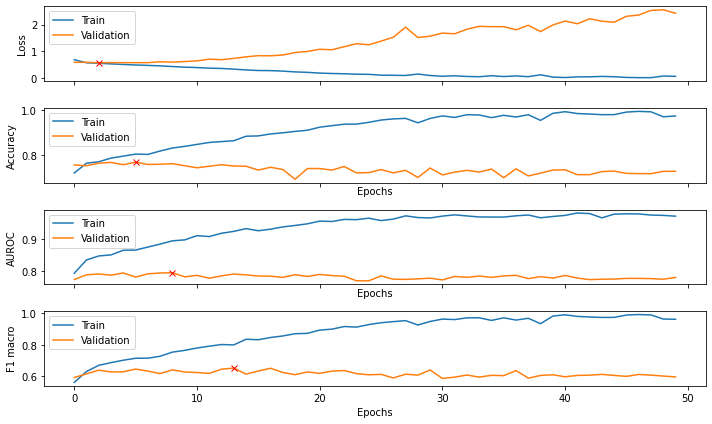

In [13]:
fig,ax = plt.subplots(4,1,figsize = (10, 6), sharex = True)
ax[0].plot(logger['epoch'], logger['train_loss'])
ax[0].plot(logger['epoch'], logger['valid_loss'])
argmin_loss = np.argmin(logger['valid_loss'])
ax[0].plot(argmin_loss, logger['valid_loss'][argmin_loss],'xr')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train','Validation'])

ax[1].plot(logger['epoch'], logger['train_acc'])
ax[1].plot(logger['epoch'], logger['valid_acc'])
argmax_acc = np.argmax(logger['valid_acc'])
ax[1].plot(argmax_acc, logger['valid_acc'][argmax_acc],'xr')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Train','Validation'])

ax[2].plot(logger['epoch'], logger['train_auc'])
ax[2].plot(logger['epoch'], logger['valid_auc'])
argmax_auc = np.argmax(logger['valid_auc'])
ax[2].plot(argmax_auc, logger['valid_auc'][argmax_auc],'xr')
ax[2].set_ylabel('AUROC')
ax[2].set_xlabel('Epochs')
ax[2].legend(['Train','Validation'])

ax[3].plot(logger['epoch'], logger['train_f1_macro'])
ax[3].plot(logger['epoch'], logger['valid_f1_macro'])
argmax_f1_macro = np.argmax(logger['valid_f1_macro'])
ax[3].plot(argmax_f1_macro, logger['valid_f1_macro'][argmax_f1_macro],'xr')
ax[3].set_ylabel('F1 macro')
ax[3].set_xlabel('Epochs')
ax[3].legend(['Train','Validation'])

fig.tight_layout()
fig.show()